In [1]:
import numpy as np
import jax
from numpy.random import multivariate_normal as mvn
from approx_post import ApproximateDistribution, AmortisedApproximation, JointDistribution, reverse_kl, forward_kl, fit_approximation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set({'figure.facecolor':'white'})

In [2]:
def create_data(model, theta_vals, num_obs, noise_cov):
    # theta_vals.shape = (num_batch, dim_x)
    num_batch, dim_theta = theta_vals.shape
    mean_vals = model(theta_vals).reshape(num_batch, -1) # mean_vals.shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = mvn(np.zeros(x_dim), noise_cov, (num_batch, num_obs)) # epsilon.shape = (num_batch, num_obs, dim_theta)
    # Add each mean on:
    samples = mean_vals[:, None, :] + epsilon # samples.shape = (num_batch, num_samples, x_dim)
    return samples

In [3]:
# First, let's define a model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [4]:
# Create artificial data:
theta_vals = np.linspace(0,5,100)[:,None]
noise_cov = 1*np.identity(ndim)
num_obs = 3
data = create_data(model, theta_vals, num_obs, noise_cov)

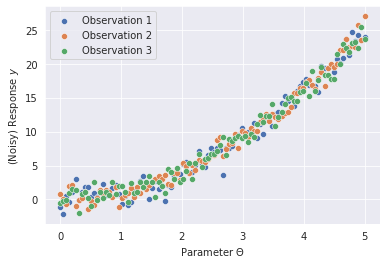

In [5]:
for i in range(num_obs):
    sns.scatterplot(x=theta_vals.flatten(), y=data[:,i,:].flatten(), label=f'Observation {i+1}')
plt.xlabel("Parameter $\Theta$")
plt.ylabel("(Noisy) Response $y$")
plt.show()

In [6]:
# Create Gaussian approximate distribution:
approx = ApproximateDistribution.gaussian(ndim)
approx = AmortisedApproximation.nn(approx, ndim)

In [7]:
# Create Joint distribution from forward model:
prior_mean = np.zeros(ndim)
prior_cov = np.identity(ndim)
joint = JointDistribution.from_model(model, noise_cov, prior_mean, prior_cov, model_grad)

In [8]:
loss = reverse_kl(approx, joint, use_reparameterisation=True)
# Need to flatten data along num_obs dimension:
approx = approx.fit(loss, data.reshape(-1, ndim), verbose=True)

Numpytainer({'chol_diag': array([100.]), 'chol_lowerdiag': array([], dtype=float64), 'mean': array(None, dtype=object)})
Numpytainer({'chol_diag': array([0.01]), 'chol_lowerdiag': array([], dtype=float64), 'mean': array(None, dtype=object)})


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [13]:
from arraytainers import Numpytainer

A = Numpytainer({'chol_lowerdiag': np.array([]), 'mean': np.array(None, dtype=object)})
B = Numpytainer({'chol_lowerdiag': np.array([]), 'mean': np.array(None, dtype=object)})

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'